In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2
import cvflow as cf
import laneFindingPipeline
from utils import ShowOpClip
from jupyterTools import src, propertySrc
%matplotlib inline

In [2]:
allFrames = laneFindingPipeline.utils.loadFrames(maxFrames=32)

In [3]:
showOpClip = ShowOpClip(allFrames['harder_challenge'][:32])

In [4]:
frame = allFrames['project'][-1]

## Development of a pipeline for identifying lane-marking pixels

### `cvflow` for visualizing OpenCV pipelines
I fell down a rabbithole on this project implementing a computational graph library for assembling my OpenCV pipelines. This was inspired (obviously) by TensorFlow. Though here I use such an approach merely for convenience of introspection rather than for allowing for code generation, I could see that being an alternate use. Towards the end of this report, I'll list this and a few other possible future improvements to this library.

The basic object in cvflow is the `Op` (aka "node"), which wraps some operation, such as a simple `Add` of two or more arrays, or more relevantly, something like `cv2.cvtColor`. Crucially, `Op` objects contain a `parents` list, which they use directly in their wrapped operation, a `object.value` property which returns the result of this operation, and a `children` list, each of whom have this object as a parent and make use of its `object.value` property.

These nodes form a directed acyclic graph (DAG) (though I do no explict test for acyclicity, I rely on it throughout to avoid `RecursionError`s), so the `object.value` properties are cached on their first evaluation so that they are not recomputed for use by multiple children. A special `Op` subclass called `BaseImage` (with subclasses `ColorImage` and `MonoImage` acting as further offenses in the ongoing violation of [YAGNI](https://en.wikipedia.org/wiki/You_aren%27t_gonna_need_it) that is this library) calls `self.invalidateCache` on the setter of the `self.value` property, which recursively calls itself on the children of the `BaseImage`. 

In [5]:
op = cf.Op()
src(op.invalidateCache)

Thus, with one such node serving as the primary user-interactive root node for the digraph, setting its `.value` results in clearing the cached values for all descendants. I have not implemented this cache-clearing cascade behavior for any other types of root nodes (e.g., `Constant` nodes such as kernel matrices), since I figured I had to draw the line somewhere on this project. I also have not tested this approach with pipelines containing multiple `BaseImage` input nodes, but the behavior should work for those as well--only nodes which are direct descendants of the currently altered node will have their cache cleared, which is as it should be. Clearing the cache for a node twice is harmless.

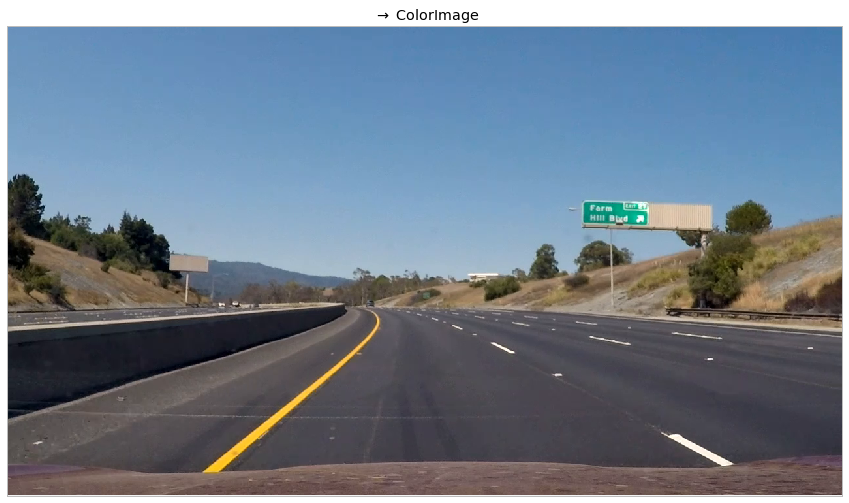

In [6]:
colorImage = cf.ColorImage()
colorImage.value = frame
colorImage.showValue();

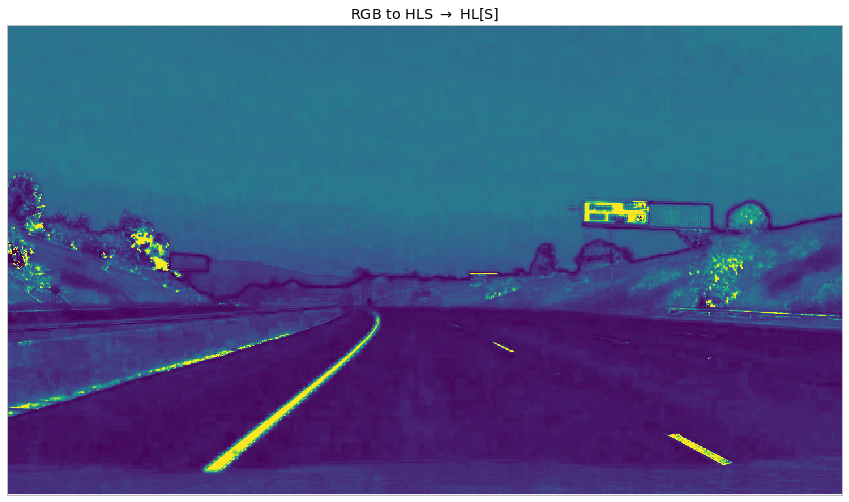

In [7]:
hls = cf.CvtColor(colorImage, cv2.COLOR_RGB2HLS)
s = cf.ColorSplit(hls, 2)
s.showValue();

Some operator overloading is also implemented.

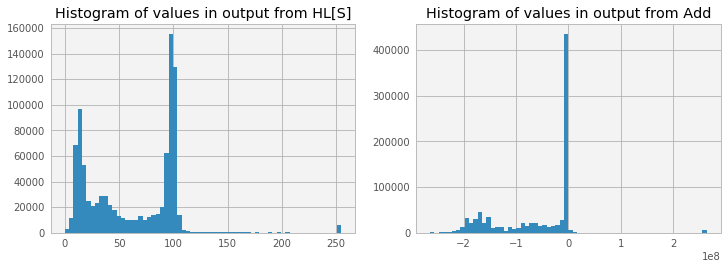

In [8]:
# Re-implement the `cf.Expand` op,
# for emphasizing outliers in a nonlinear way.
x = cf.AsType(s, 'float64')
centered = x - x.max() / 2
neg = centered < 0
pos = centered >= 0
widenedFlippedSign = centered ** 4
expanded = -abs(widenedFlippedSign & neg) + (widenedFlippedSign & pos)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, x in enumerate([s, expanded]):
    img = x.value

    ax = axes[i]
    ax.hist(img.ravel(), bins=64);
    ax.set_title('Histogram of values in output from %s' % x)

A second useful effect of this DAG structure is that requesting `object.value` on some leaf node propagates the execution of wrapped operations only up through direct ancestor nodes, without wastefully computing the results of side branches. This allows for the addition of speculative chains of operations that do not lead to the final result, for exploration purposes without slowing down the main execution, though there would be no reason to keep these in production. Analogously to the use of preprocessor directives in compiled languages, full-DAG operations take place only at instantiation time (and for some plotting and introspection purposes not necessary for executing the graph), not at execution.

Subclassing `Op` is the `MultistepOp` class, which adds additional logic supporting nodes that wrap subgraphs of other nodes in convenient bundles. This became a primary motivation for the (perhaps inadvisable) creation of this library when I noticed that certain motifs of repeated OpenCV operations were useful in my pipeline. 

Of course, such reused multi-step operations in OpenCV could be accomplished just fine through normal functions, but it would be difficult to introspect their structure and intermediate stages. This was the other major motivation for this library. Upon request, any node in the digraph can assemble an object representing the entire digraph in a convenient form (a combination of networkx and graphviz digraph objects). Courtesy of graphviz, this representation can be displayed in a Jupyter notebook, or written to various file formats.

We'll now use this to depict the DAG we've just constructed.

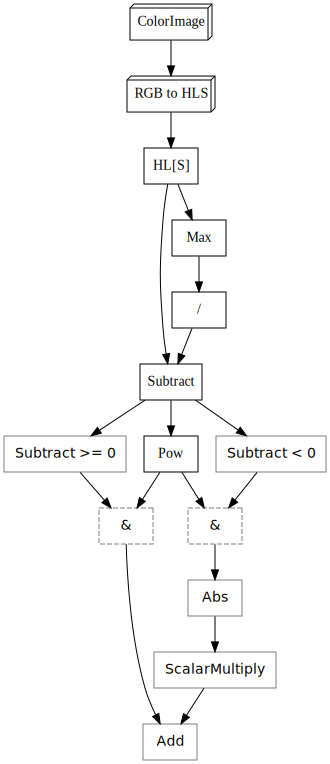

In [9]:
expanded.draw(addKey=False)

The key used for these diagrams is always as follows:

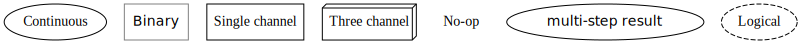

In [10]:
label, gv, nx = cf.misc.makeKeySubgraph()
gv

## Preprocessing pipeline

### A simple pipeline

With significant effort invested to create this library, we can now use it to prototype some image pre-processing pipelines.

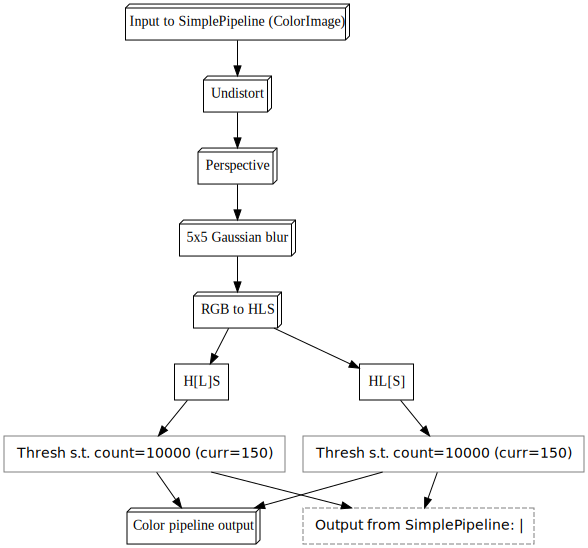

In [11]:
pipeline = cf.SimplePipeline()
pipeline.getSubgraph()

This pipeline is fairly simple--we use the saturation channel to detect the yellow left line, and the lightness channel to detect the white right line. It works for most of the project video.

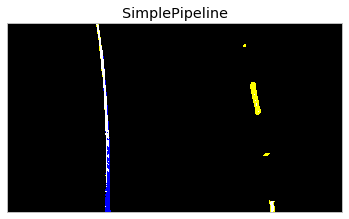

In [12]:
linePixels = pipeline(frame)
color = pipeline.colorOutput.value
laneFindingPipeline.utils.show(color, title=pipeline);

To find only relevant pixels in each channel, I use the complicated (but not `MultistepOp`) `CountSeekingThreshold` op.

In [13]:
thresh = pipeline.getByKind(cf.CountSeekingThreshold)[0]
propertySrc(thresh)

Basically, we set a `goalCount` of around 10000 pixels, then, rely on the fact that the number of thresholded pixels is monotonic in the current threshold to do a bifurcation search for the threshold that brings us within `countTol` of the goal.

It occurs to me that such a dynamic thresholding might already be implemented in OpenCV, but, since other Sobel-only methods actually proved more useful than thresholding of any kind, I didn't pursue this further.

The problem with this or a fixed-threshold approach is that occasionally large splotches of brightness would come along in the monitored channel. For any reasonable `goalCount`, these splotches would quickly drive the threshold up to the maximum of 255, resulting in a mask empty of identified pixels.

### A more complicated preprocessing

In [14]:
def showOpClip(op):
    pipeline = op.getByKind(cf.Pipeline, index=0)
    
    from os import system
    import time
    system('mkdir -p doc/images/')
    fpath = 'doc/images/%s-%s.gif' % (type(pipeline).__name__, type(op).__name__)
    
    def f(frame):
        pipeline(frame)
        return op.showMembersFast(show=False)[0].X
    return laneFindingPipeline.utils.transformVideo(allFrames['harder_challenge'][:32], fpath, f, pbar=False)

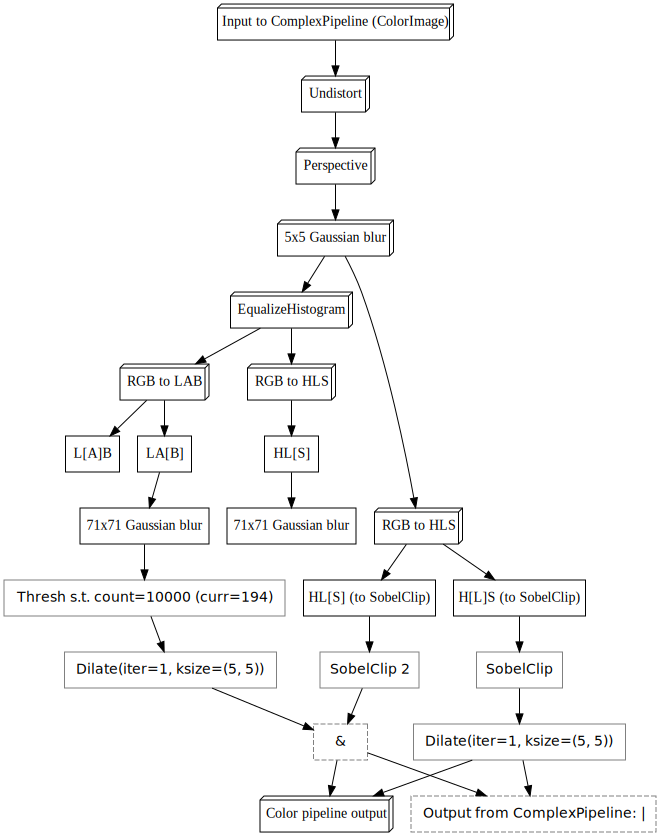

In [15]:
pipeline = cf.ComplexPipeline()
# Initialize the input.
pipeline(allFrames['harder_challenge'][-1]);
pipeline.getSubgraph()

Though this pipeline was not used, it has a couple notable features. First, there are two leaf nodes--L[A]B and a blurred HL[S}--which do not contribute to the final output. These are included in some vlsualizations, but not computed for the purposes of finding actual lane markings.

#### The `SobelClip` `MultiOp`

Second, in addition to the `EqualizeHistogram` operation, which internally uses `cv2.equalizeHist`, there is a previously unseen operation called `SobelClip`. This is a subclass of `MultistepOp`.

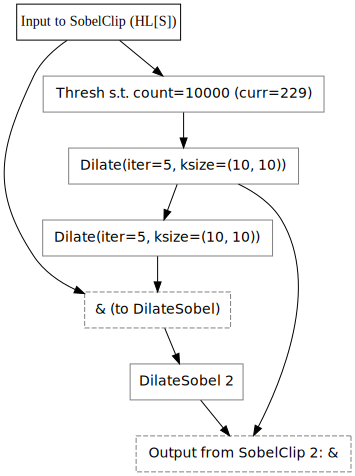

In [16]:
aSobelClip = pipeline.getByKind(cf.SobelClip)[0]
aSobelClip.getSubgraph()

This operation works by first using our previously-discussed `CountSeekingThreshold` to detail an initial set of interesting pixels. This set is then slightly dilated to produce a restrictive mask for use in the final `&`, and dilated more to produce a permissive mask on the original data. this prevents the subsequent application of a `DilateSobel` operation (discussed below) from activating on irrelevant features (per one definition). Finally, the lesser dilation is used as a mask, alowing us to be relatively liberal with what we allow the wider mask to present to the `DilateSobel` for consideration.

(Note that outputs from `showOpClip` like the following, though static in PDF renderings of this notebook, are animated in the notebook visible on Github.)

In [17]:
showOpClip(aSobelClip);

doc/images/ComplexPipeline-SobelClip.gif


<img src="doc/images/ComplexPipeline-SobelClip.gif" />

While this might sometimes produce some useful results, as in the example above, its reliance on on a threshold makes it vulnerable to large splotches of brightness or darkness in the observed channel. My later work made me question what value these dilated-threshold masks were adding to the underlying Sobel-based method.

#### The Dilate Sobel `MultistepOp`
On the other hand, one composite operation that I did find repeatedly useful was a combination of multiple asymmetric Sobel operations.

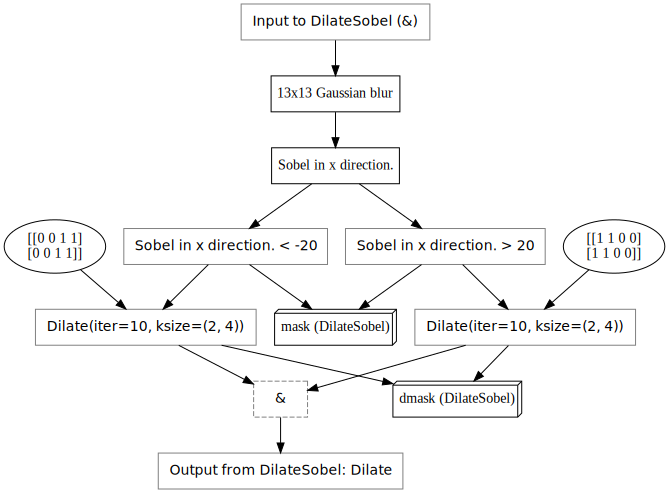

In [18]:
aDilateSobel = pipeline.getByKind(cf.DilateSobel)[0]
# show ndarray kernels explicitly
for dilate in aDilateSobel.getMembersByType(cf.Dilate):
    for parent in dilate.parents:
        if isinstance(parent, cf.Constant):
            # Show the kernels in the diagram, but not in the preview clip.
            parent.hidden = parent.isVisualized = False
            if isinstance(parent.value, np.ndarray):
                parent.nodeName = '%s' % parent.value
aDilateSobel.getSubgraph()

Note that, here, I've unhidden two constant dilation kernels.

Sobel in the x direction returns a continuous-valued array of positive and negative values, indicating locations where the x-derivative of the image is positive or negative, respectively. By using two thresholds, we separately extract these two rising- and falling-edge signals. Since lane lines are generally always a fixed number of pixels wide in our images, **we generally want only vertical rising edges that are quickly followed by falling edges** (for "ridges"; this is reversed for "troughs", which is how lane lines might manifest in some channels).

We can extract only such edge combinations by differentially dilating the our two thresholded sobel signals. Since dilation can be thought of as pulling a pixel value from neighbors indicated by nonzero locations in the centered kernel, the two constant kernels shown in the diagram above have the effect of dilating these found pixels exclusively to one side or the other. When rising edges are dilated to the right, and falling to the left, This filter discovers vertical ridges of a particular width. This is visible in the color composite images below, which show the two masks before and after this dilation, as well as the intersection that appears.

In this particular example, the input to the `DilateSobel` comes from an enclosing `SobelClip` operation, so the true edge is enclosed in a wide-masked bounding tube. While the initial Sobel convolution of the `DilateSobel` picks up these outer edges as well, the intersection of the differentially dilated positive and negative thresholds correctly excludes these outer edges as being part of a structure of the incorrect width.

In the next pipeline, I do use `DilateSobel` directly without `SobelClip`, and so this outer bounding tube does not take effect.

In [19]:
showOpClip(aDilateSobel);

/mnt/wdblue/Dropbox/Projects/Lane Lines/cvflow/misc.py:400: UserWarning: Using a non-unity scaling for float image data. This might cause flashing in output.
  warn('Using a non-unity scaling for float image data. This might cause flashing in output.')


doc/images/ComplexPipeline-DilateSobel.gif


<img src="doc/images/ComplexPipeline-DilateSobel.gif" />

### Full pipeline

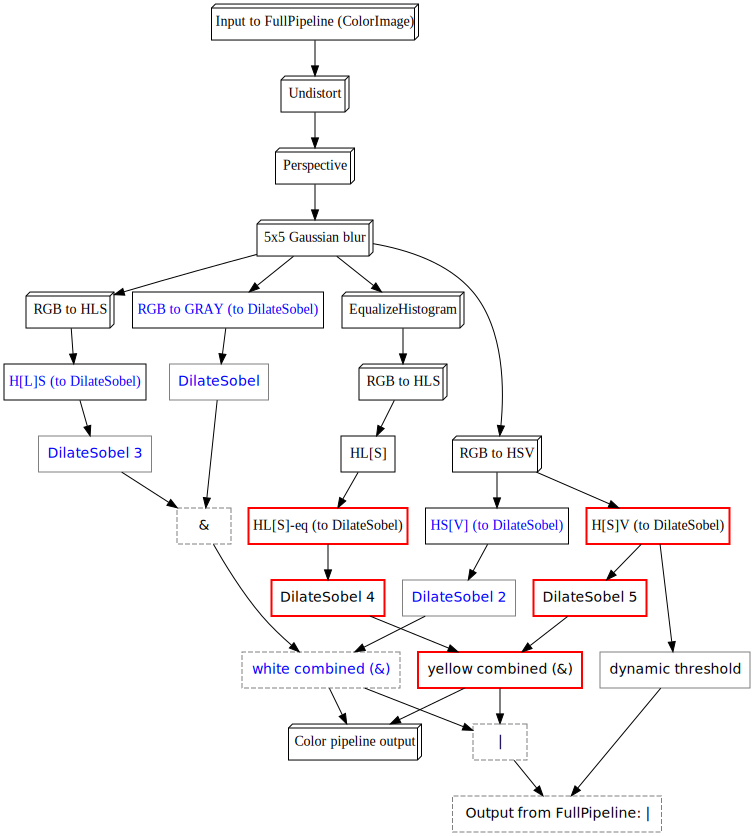

In [20]:
pipeline = cf.FullPipeline()
pipeline.getSubgraph()

In [21]:
showOpClip(pipeline);

doc/images/FullPipeline-FullPipeline.gif


<img src="doc/images/FullPipeline-FullPipeline.gif" />

## Curve fitting

### Regularization and RANSAC

### Meters per pixel

## Final result

# Future work
* Use a predictive model for the evolution of the lane lines--e.g., fit a polynomial in time.
* Use a more useful quality metric (at least MSE from the fit) to weight the new polynomials when averaging them with previous ones.
* Use optical flow, or maybe temporal averaing to remove reflections from the windshield.
* Use an ROI mask
* Use a shadow mask for passing cars